In [13]:
! pip install transformers datasets rouge-score
! pip install transformers[torch]
! pip install accelerate -U
! pip install rouge

In [14]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from rouge import Rouge
from datasets import load_dataset
import matplotlib.pyplot as plt

In [15]:
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

c:\Users\vijay\anaconda3\envs\aroha\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [16]:
max_article_length = 500
max_summary_length = 50

In [17]:
def process_data_to_model_inputs(batch):
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=max_article_length)
    outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=max_summary_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["labels"] = outputs.input_ids

    return batch

In [18]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

In [19]:
train_data = dataset['train']
train_df = pd.DataFrame(train_data).head(100)

In [20]:
validation_data = dataset['validation']
validation_df = pd.DataFrame(validation_data).head(10)

In [21]:
test_data = dataset['test']
test_df = pd.DataFrame(test_data).head(10)

In [22]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

In [23]:
train_dataset = train_dataset.map(process_data_to_model_inputs, batched=True)
val_dataset = val_dataset.map(process_data_to_model_inputs, batched=True)
test_dataset = test_dataset.map(process_data_to_model_inputs, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 238.09 examples/s]


In [24]:
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [25]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [26]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=1,
    logging_first_step=True,
)

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [28]:
trainer.train()

c:\Users\vijay\anaconda3\envs\aroha\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  4%|▍         | 1/25 [01:00<23:57, 59.90s/it]

{'loss': 2.2746, 'learning_rate': 4.8e-05, 'epoch': 0.04}


  8%|▊         | 2/25 [02:24<28:36, 74.62s/it]

{'loss': 2.7041, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.08}


 12%|█▏        | 3/25 [03:29<25:44, 70.23s/it]

{'loss': 2.5089, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.12}


 16%|█▌        | 4/25 [04:21<21:59, 62.84s/it]

{'loss': 2.5208, 'learning_rate': 4.2e-05, 'epoch': 0.16}


 20%|██        | 5/25 [05:04<18:34, 55.72s/it]

{'loss': 2.9372, 'learning_rate': 4e-05, 'epoch': 0.2}


 24%|██▍       | 6/25 [05:42<15:43, 49.65s/it]

{'loss': 2.7985, 'learning_rate': 3.8e-05, 'epoch': 0.24}


 28%|██▊       | 7/25 [06:18<13:32, 45.12s/it]

{'loss': 2.0739, 'learning_rate': 3.6e-05, 'epoch': 0.28}


 32%|███▏      | 8/25 [06:53<11:55, 42.11s/it]

{'loss': 1.8618, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.32}


 36%|███▌      | 9/25 [07:30<10:49, 40.58s/it]

{'loss': 3.4921, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.36}


 40%|████      | 10/25 [08:08<09:53, 39.54s/it]

{'loss': 3.2881, 'learning_rate': 3e-05, 'epoch': 0.4}


 44%|████▍     | 11/25 [08:47<09:11, 39.38s/it]

{'loss': 2.4444, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.44}


 48%|████▊     | 12/25 [09:26<08:30, 39.24s/it]

{'loss': 3.2968, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.48}


 52%|█████▏    | 13/25 [10:04<07:48, 39.08s/it]

{'loss': 1.8915, 'learning_rate': 2.4e-05, 'epoch': 0.52}


 56%|█████▌    | 14/25 [10:40<06:58, 38.08s/it]

{'loss': 2.5474, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.56}


 60%|██████    | 15/25 [11:16<06:15, 37.52s/it]

{'loss': 2.1481, 'learning_rate': 2e-05, 'epoch': 0.6}


 64%|██████▍   | 16/25 [11:51<05:30, 36.76s/it]

{'loss': 2.3294, 'learning_rate': 1.8e-05, 'epoch': 0.64}


 68%|██████▊   | 17/25 [12:26<04:49, 36.21s/it]

{'loss': 3.8027, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.68}


 72%|███████▏  | 18/25 [13:03<04:15, 36.48s/it]

{'loss': 3.0878, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.72}


 76%|███████▌  | 19/25 [13:41<03:40, 36.71s/it]

{'loss': 2.1607, 'learning_rate': 1.2e-05, 'epoch': 0.76}


 80%|████████  | 20/25 [14:16<03:01, 36.21s/it]

{'loss': 1.9687, 'learning_rate': 1e-05, 'epoch': 0.8}


 84%|████████▍ | 21/25 [14:52<02:25, 36.32s/it]

{'loss': 1.6606, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.84}


 88%|████████▊ | 22/25 [15:27<01:47, 35.89s/it]

{'loss': 2.8638, 'learning_rate': 6e-06, 'epoch': 0.88}


 92%|█████████▏| 23/25 [16:02<01:11, 35.59s/it]

{'loss': 2.2091, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.92}


 96%|█████████▌| 24/25 [16:37<00:35, 35.26s/it]

{'loss': 1.5916, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.96}


100%|██████████| 25/25 [17:11<00:00, 35.02s/it]

{'loss': 1.9719, 'learning_rate': 0.0, 'epoch': 1.0}


                                               
100%|██████████| 25/25 [17:46<00:00, 35.02s/it]

{'eval_loss': 4.128125190734863, 'eval_runtime': 34.57, 'eval_samples_per_second': 0.289, 'eval_steps_per_second': 0.087, 'epoch': 1.0}


100%|██████████| 25/25 [17:54<00:00, 42.96s/it]

{'train_runtime': 1074.2941, 'train_samples_per_second': 0.093, 'train_steps_per_second': 0.023, 'train_loss': 2.4973750352859496, 'epoch': 1.0}


TrainOutput(global_step=25, training_loss=2.4973750352859496, metrics={'train_runtime': 1074.2941, 'train_samples_per_second': 0.093, 'train_steps_per_second': 0.023, 'train_loss': 2.4973750352859496, 'epoch': 1.0})

In [29]:
# Extract training and evaluation losses from log history
training_losses = [log.get('loss', None) for log in trainer.state.log_history]
eval_losses = [log.get('eval_loss', None) for log in trainer.state.log_history]

# Remove None values (steps where corresponding loss is not logged)
training_losses = [loss for loss in training_losses if loss is not None]
eval_losses = [loss for loss in eval_losses if loss is not None]

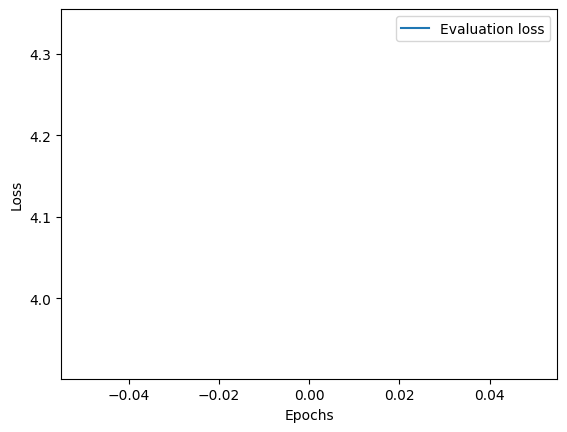

In [30]:
# Plot the losses
plt.plot(eval_losses, label='Evaluation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

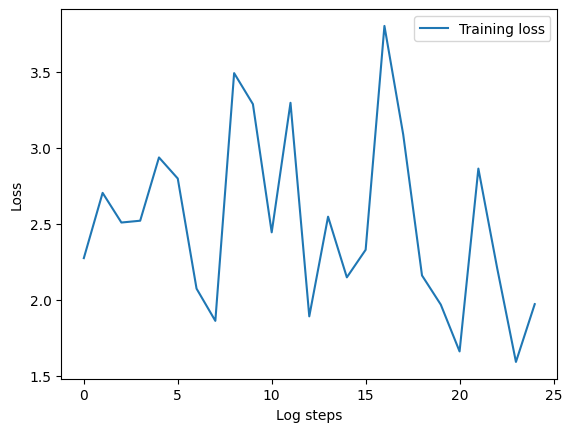

In [31]:
plt.plot(training_losses, label='Training loss')
plt.xlabel('Log steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
trainer.save_model("./t5_transfer_learning")

In [33]:
generated_summaries = trainer.predict(test_dataset)

100%|██████████| 3/3 [00:35<00:00, 11.93s/it]


In [34]:
predicted_ids = generated_summaries.predictions[0].argmax(-1)

In [35]:
test_df['summary'] = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

In [36]:
rouge = Rouge()

test_df['rouge_scores'] = test_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [37]:
test_df.to_csv('t5_transfer_learning.csv.zip', index=False, compression='zip')

In [38]:
rouge_scores = test_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores.to_csv('t5_transfer_learning_rouge.csv', index=True)

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.502994,0.291066,0.489898
precision,0.603506,0.333387,0.588960
f1-score,0.545280,0.307786,0.531538


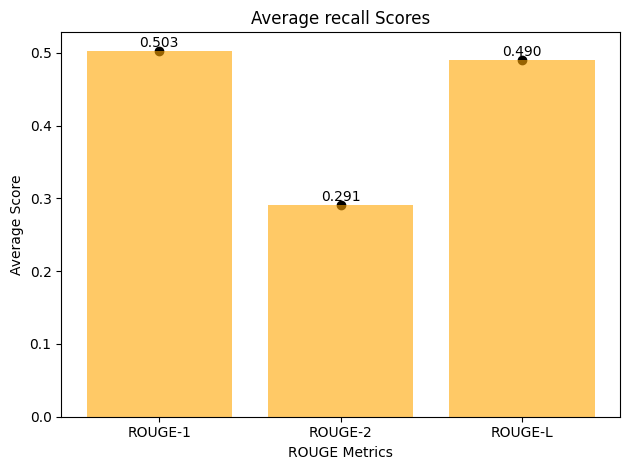

In [39]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

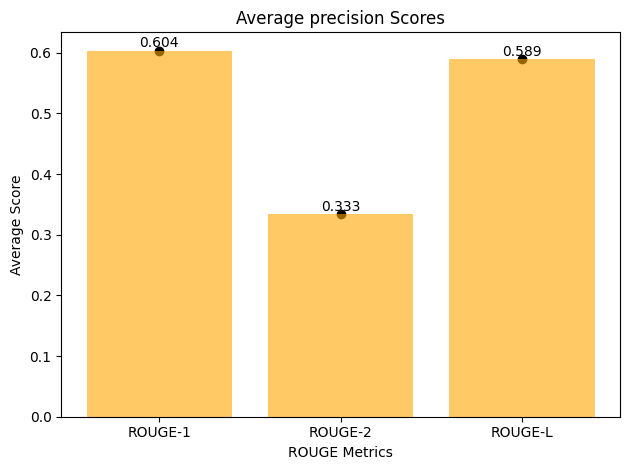

In [40]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

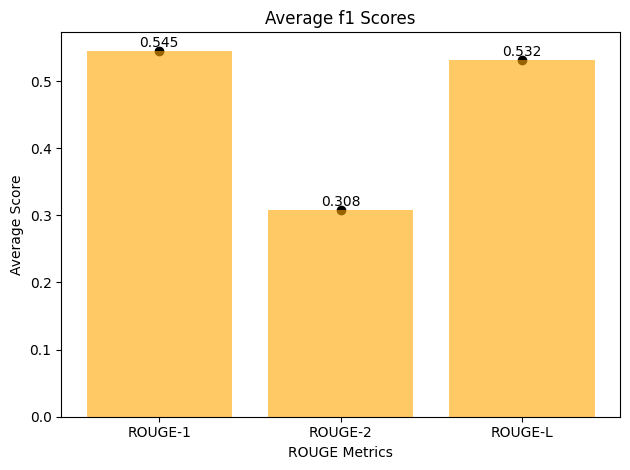

In [41]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

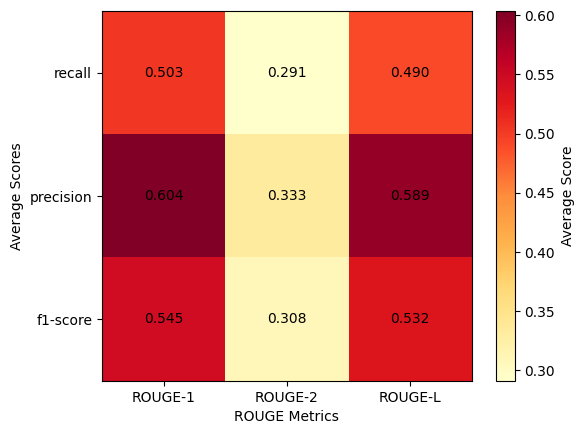

In [42]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()